In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-dataset-sri-lanka-crisis/SriLankaTweets.csv


In [5]:
!pip install opendatasets

In [6]:
import opendatasets as op

In [7]:
op.download("https://www.kaggle.com/datasets/vishesh1412/twitter-dataset-sri-lanka-crisis")
op.download("https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle username:

  ashleshkhajbage


Your Kaggle Key:

  ································


100%|██████████| 1.86M/1.86M [00:00<00:00, 6.19MB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ashleshkhajbage


Your Kaggle Key:

  ································


100%|██████████| 721k/721k [00:00<00:00, 1.56MB/s]

In [8]:
dataset_emotion = "emotions-dataset-for-nlp"


# Import Packages

In [9]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM ,Conv2D, Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib as mpl

# First Step:
building a recurrent neural network capable of analyzing emotions, using a dataset that includes a number of emotions.

In [10]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
porter = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
class Emotion:
  def __init__(self, datasetFolder, batch_size, validation_split, optimizer, loss, epochs):
    self.datasetFolder = datasetFolder
    self.batch_size = batch_size
    self.validation_split = validation_split
    self.optimizer = optimizer
    self.loss = loss
    self.epochs = epochs
  def readDatasetCSV(self):
    trainDataset = pd.read_csv(os.path.join(self.datasetFolder, "train.txt"), names=['Text', 'Emotion'], sep=';')
    testDataset = pd.read_csv(os.path.join(self.datasetFolder, "test.txt"), names=['Text', 'Emotion'], sep=';')
    validDataset = pd.read_csv(os.path.join(self.datasetFolder, "val.txt"), names=['Text', 'Emotion'], sep=';')
    list_dataset = [trainDataset, testDataset, validDataset]
    self.dataset = pd.concat(list_dataset)
  def FeaturesLables(self):
    self.features = self.dataset['Text']
    self.labels = self.dataset['Emotion']  
  def splitDataset(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.features,
                                                                            self.labels, 
                                                                            test_size = self.validation_split)
  def CleanFeatures(self):
    self.features = self.features.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
    self.features = self.features.apply(lambda wrd: ''.join(wrd))
  def tokenizerDataset(self):
    self.tokenizer = Tokenizer(num_words=5000)
    self.tokenizer.fit_on_texts(self.features)
    train = self.tokenizer.texts_to_sequences(self.features)
    self.features = pad_sequences(train)
    le = LabelEncoder()
    self.labels = le.fit_transform(self.labels)
    self.vocabulary = len(self.tokenizer.word_index)
  def label_categorical(self):
    self.labels = to_categorical(self.labels, 6)
  def glove_word_embedding(self, file_name):
    self.embeddings_index = {}
    file_ = open(file_name)
    for line in file_:
        arr = line.split()
        single_word = arr[0]
        w = np.asarray(arr[1:],dtype='float32')
        self.embeddings_index[single_word] = w
    file_.close()
    max_words = self.vocabulary + 1
    word_index = self.tokenizer.word_index
    self.embedding_matrix = np.zeros((max_words,300)).astype(object)
    for word , i in word_index.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector  
  def model(self):
    m = Sequential()
    m.add(Input(shape=(self.features.shape[1], )))
    m.add(Embedding(self.vocabulary + 1,300))
    m.add(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    m.add(Dense(6, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    self.m = m
  def compiler(self):
    self.m.compile(loss= self.loss,optimizer=self.optimizer,metrics=['accuracy'])
  def fit(self):
    earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
    self.history_training = self.m.fit(self.X_train, self.Y_train, epochs= self.epochs,batch_size = self.batch_size,
                                       callbacks=[ earlyStopping])

In [12]:
emotion = Emotion(dataset_emotion, 256, 0.1, 'adam', 'categorical_crossentropy', 120)
emotion.readDatasetCSV()
emotion.dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [13]:
emotion.FeaturesLables()
emotion.CleanFeatures()
emotion.features.head()

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [14]:
emotion.labels.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [15]:
emotion.tokenizerDataset()
emotion.features

array([[   0,    0,    0, ...,  138,    2,  625],
       [   0,    0,    0, ...,    3,   21, 1383],
       [   0,    0,    0, ...,    2,  495,  420],
       ...,
       [   0,    0,    0, ...,    5,  215,  191],
       [   0,    0,    0, ...,   30,   57, 2181],
       [   0,    0,    0, ...,   75,    5,   70]], dtype=int32)

In [16]:
emotion.labels

array([4, 4, 0, ..., 2, 2, 2])

In [17]:
emotion.features.shape

(20000, 63)

In [18]:
emotion.label_categorical()

In [19]:
emotion.labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [20]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-11-16 16:47:20--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-16 16:47:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.42MB/s    in 4m 1s   

2022-11-16 16:51:23 (3.41 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [21]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [22]:

emotion.splitDataset()
emotion.glove_word_embedding("glove.6B.300d.txt")

In [23]:
emotion.model()
emotion.m.layers[0].set_weights([emotion.embedding_matrix])
emotion.m.layers[0].trainable = False

2022-11-16 16:52:03.055113: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
emotion.compiler()
emotion.m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 63, 300)           5129100   
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 5,294,994
Trainable params: 165,894
Non-trainable params: 5,129,100
_________________________________________________________________


In [25]:
emotion.fit()

Epoch 1/120


2022-11-16 16:52:03.545506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


71/71 [==============================] - 36s 469ms/step - loss: 1.3721 - accuracy: 0.4829
Epoch 2/120
71/71 [==============================] - 33s 467ms/step - loss: 0.7673 - accuracy: 0.7314
Epoch 3/120
71/71 [==============================] - 33s 467ms/step - loss: 0.4061 - accuracy: 0.8595
Epoch 4/120
71/71 [==============================] - 33s 464ms/step - loss: 0.2766 - accuracy: 0.9009
Epoch 5/120
71/71 [==============================] - 33s 469ms/step - loss: 0.2169 - accuracy: 0.9171
Epoch 6/120
71/71 [==============================] - 33s 467ms/step - loss: 0.1791 - accuracy: 0.9278
Epoch 7/120
71/71 [==============================] - 33s 470ms/step - loss: 0.1514 - accuracy: 0.9394
Epoch 8/120
71/71 [==============================] - 33s 467ms/step - loss: 0.1348 - accuracy: 0.9439
Epoch 9/120
71/71 [==============================] - 33s 465ms/step - loss: 0.1243 - accuracy: 0.9468
Epoch 10/120
71/71 [==============================] - 33s 467ms/step - loss: 0.1125 - accuracy

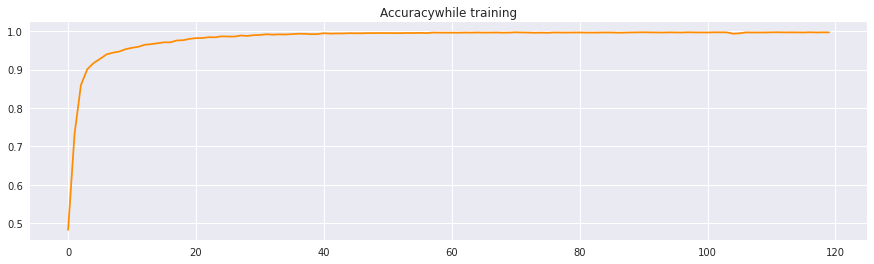

In [26]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['accuracy'], 'darkorange', label = 'Accuracy')
plt.title("Accuracywhile training")
plt.show()

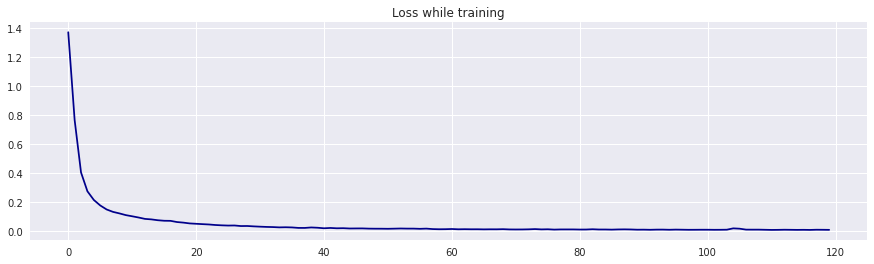

In [27]:
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['loss'], 'darkblue', label = 'Loss')
plt.title("Loss while training")
plt.show()

In [28]:
emotion.m.evaluate(emotion.X_test, emotion.Y_test, batch_size = 256)

8/8 [==============================] - 1s 121ms/step - loss: 0.3051 - accuracy: 0.9360


[0.3050912916660309, 0.9359999895095825]

In [29]:
y_pred = emotion.m.predict(emotion.X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([3, 0, 2, ..., 2, 1, 2])

In [30]:
y_test = np.argmax(emotion.Y_test, axis = 1)
y_test

array([3, 0, 2, ..., 2, 1, 2])

In [31]:
from sklearn.metrics import accuracy_score as acc
print(acc(y_pred, y_test))

0.936


In [32]:
res = tf.math.confusion_matrix(y_pred,y_test).numpy()

cm = pd.DataFrame(res,
                     index = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'], 
                     columns = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'])
cm

,sadness,anger,love,surprise,fear,joy
sadness,260,10,2,0,4,0
anger,3,214,5,0,5,10
love,3,3,651,25,6,5
surprise,1,0,18,131,1,1
fear,6,8,1,0,563,0
joy,0,11,0,0,0,53


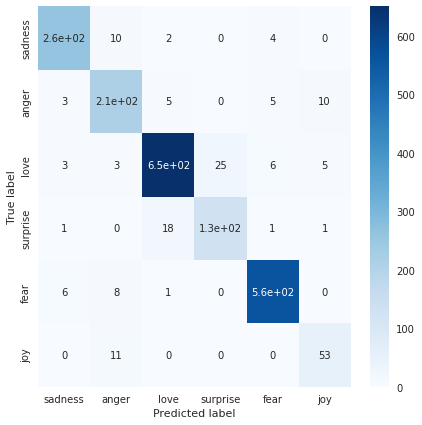

In [33]:
import seaborn as sns
figure = plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
emotion.m.save("emotion.h5")

# Second Step:
Using the model that has been trained to sort tweets based on sentiment with a rating ratio.

In [35]:
Tweets = "twitter-dataset-sri-lanka-crisis/SriLankaTweets.csv"
Tweets = pd.read_csv(Tweets)
Tweets.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1546235784730230785,1546089912042127362,1.657486e+12,2022-07-10 20:51:53,0,NaN,@MrJonasDanner Das geht doch seit Beginn der B...,de,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MrJonasDanner', 'name': 'Jon...",NaN,NaN,NaN,NaN
1,1,1546235779906781186,1546235779906781186,1.657486e+12,2022-07-10 20:51:52,0,NaN,Artículo lúcido y bien informado sobre la cris...,es,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,2,1546235777633468416,1546235777633468416,1.657486e+12,2022-07-10 20:51:51,0,NaN,En argentina y después de lo de Sri Lanka la g...,es,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,3,1546235770582847496,1546185673593524225,1.657486e+12,2022-07-10 20:51:50,0,NaN,@Haqeeqat_TV Ab na daro aur sikho in Sri lank...,hi,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Haqeeqat_TV', 'name': 'Haqee...",NaN,NaN,NaN,NaN
4,4,1546235754342498308,1546235754342498308,1.657486e+12,2022-07-10 20:51:46,0,NaN,Resigned or Arrested? 1. Sri Lanka's presiden...,et,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [36]:
Tweets.describe()

,Unnamed: 0,id,conversation_id,created_at,timezone,user_id,user_id_str,day,hour,video,...,near,geo,source,user_rt_id,user_rt,retweet_id,retweet_date,translate,trans_src,trans_dest
count,10004.00000,1.000400e+04,1.000400e+04,1.000400e+04,10004.0,1.000400e+04,1.000400e+04,10004.0,10004.000000,10004.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,5001.50000,1.546203e+18,1.545351e+18,1.657478e+12,0.0,7.201205e+17,7.201205e+17,7.0,18.183727,0.158437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2888.05038,1.702829e+13,1.817498e+16,4.059854e+06,0.0,6.565444e+17,6.565444e+17,0.0,1.131568,0.365168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00000,1.546176e+18,4.317868e+17,1.657472e+12,0.0,7.592490e+05,7.592490e+05,7.0,16.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2500.75000,1.546188e+18,1.546161e+18,1.657475e+12,0.0,5.259509e+08,5.259509e+08,7.0,17.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5001.50000,1.546201e+18,1.546189e+18,1.657478e+12,0.0,9.101587e+17,9.101587e+17,7.0,18.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7502.25000,1.546217e+18,1.546208e+18,1.657482e+12,0.0,1.383220e+18,1.383220e+18,7.0,19.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,10003.00000,1.546236e+18,1.546236e+18,1.657486e+12,0.0,1.546220e+18,1.546220e+18,7.0,20.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
Tweets['language'].unique()

array(['de', 'es', 'hi', 'et', 'en', 'in', 'fr', 'tr', 'qht', 'it', 'ar',
       'lt', 'und', 'ca', 'tl', 'qme', 'pt', 'ur', 'pl', 'zxx', 'nl',
       'sv', 'bn', 'cs', 'ht', 'ta', 'da', 'qam', 'ro', 'si', 'fi', 'el',
       'sl', 'cy', 'th', 'no', 'mr', 'kn', 'fa', 'ml', 'hu', 'lv', 'am',
       'ru', 'vi', 'ja', 'ne', 'te', 'gu'], dtype=object)

# DataSet Preprocessing And Preparation

In [38]:
Tweets = Tweets.loc[Tweets['language'] == 'en']
len(Tweets)

5008

In [39]:
Tweets['tweet'].dropna()

5        Sri Lanka protesters vow to occupy presidentia...
7        @cricketbetting @sampsoncollins @Richard_Mann1...
8        @CeyTamAtheist Worship animals hoping for divi...
10       Yesterday it was Sri Lanka. Today it's Albania...
11       Groundwater shortage is known, flooding too. W...
                               ...                        
9993     @narendramodi ji are you aware of what's happe...
9994     "The United States, together with many other m...
9995     @Swamy39 You never know or get what people are...
9997     Education minister is busy in cutting ribbons ...
10003    Are you going to attack the peaceful protester...
Name: tweet, Length: 5008, dtype: object

In [40]:
def preprocessingText(sentences):
  sentences = sentences.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  return sentences

In [41]:
Tweets['tweet'] = preprocessingText(Tweets['tweet'])
Tweets.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
5,5,1546235750446170113,1546235750446170113,1.657486e+12,2022-07-10 20:51:45,0,NaN,sri lanka protesters vow to occupy presidentia...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
7,7,1546235749594439683,1544613357034110976,1.657486e+12,2022-07-10 20:51:45,0,NaN,cricketbetting sampsoncollins richardmann11 pa...,en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'cricketbetting', 'name': 'Ed...",NaN,NaN,NaN,NaN
8,8,1546235748357062657,1546029883591106562,1.657486e+12,2022-07-10 20:51:44,0,NaN,ceytamatheist worship animals hoping for divin...,en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'CeyTamAtheist', 'name': 'Cey...",NaN,NaN,NaN,NaN
10,10,1546235733685555201,1546235733685555201,1.657486e+12,2022-07-10 20:51:41,0,NaN,yesterday it was sri lanka today its albania i...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
11,11,1546235705747202051,1546235705747202051,1.657486e+12,2022-07-10 20:51:34,0,NaN,groundwater shortage is known flooding too we ...,en,"['srilanka', 'baerbock', 'lanz', 'annewill']",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [42]:
features = Tweets['tweet']
features.head()

5     sri lanka protesters vow to occupy presidentia...
7     cricketbetting sampsoncollins richardmann11 pa...
8     ceytamatheist worship animals hoping for divin...
10    yesterday it was sri lanka today its albania i...
11    groundwater shortage is known flooding too we ...
Name: tweet, dtype: object

In [43]:
len(features)
features.shape

(5008,)

In [44]:
tweets = emotion.tokenizer.texts_to_sequences(features)
tweets = np.array(tweets).reshape(-1)
tweets = pad_sequences(tweets, maxlen= 63)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [45]:
tweets

array([[   0,    0,    0, ...,    4,  315,  185],
       [   0,    0,    0, ...,  932,   11,    5],
       [   0,    0,    0, ..., 1306,    4, 1097],
       ...,
       [   0,    0,    0, ...,   95,  134,   32],
       [   0,    0,    0, ..., 1748,   21,   22],
       [   0,    0,    0, ...,    5,  638,  127]], dtype=int32)

In [46]:
tweets.shape

(5008, 63)

## Using the Sentiment analysis Model

In [47]:
sentiment_labels = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
sentiment_labels_encoding = [0, 1, 2, 3, 4, 5]


In [48]:
results_sen_tweets = emotion.m.predict(tweets, batch_size = 256)

sentiments = []
for i in results_sen_tweets:
  res = np.argmax(i, axis = 0)
  sentiments.append([sentiment_labels_encoding[res], i[res]])
len(sentiments)

5008

In [49]:
sentiments[:10]

[[2, 0.63529515],
 [4, 0.83926535],
 [2, 0.99661934],
 [2, 0.8177028],
 [2, 0.86995065],
 [1, 0.4435052],
 [2, 0.5032124],
 [4, 0.8834184],
 [0, 0.79591644],
 [0, 0.9088038]]

### A graph showing the distribution of tweeters' feelings

In [50]:
def count_sent(sentiments, depending_on):
  c = 0
  for i in sentiments:
    if i[0] == depending_on:
      c = c + 1
  return c

In [51]:
arr = []
for i in sentiment_labels_encoding:
  arr.append(count_sent(sentiments, i))

In [52]:
arr

[1148, 896, 2262, 123, 470, 109]

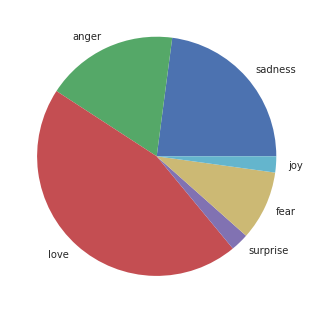

In [53]:
plt.pie(arr, labels = sentiment_labels)
plt.show()

## The hierarchical distribution of each feeling:
This stage aims to determine the degree of convergence in terms of the single feeling of the tweeters, depending on the aggregation process based on the Euclidean distance, which depends on the percentage of feeling classification.

### Dendrogram for Each Sentiment

In [54]:
def each_sent(sentiments, depending_on):
  arr = []
  for i in sentiments:
    if i[0] == depending_on:
      arr.append(i)
  return arr

In [55]:
arr = []
for i in sentiment_labels_encoding:
  arr.append(each_sent(sentiments, i))

In [56]:
import scipy.cluster.hierarchy as shc
def draw_dendrogram(sentiments, title):
  plt.figure(figsize=(15, 15))
  plt.title(title)
  clusters = shc.linkage(sentiments, 
              method='ward', 
              metric="euclidean")
  shc.dendrogram(Z=clusters)
  plt.show()

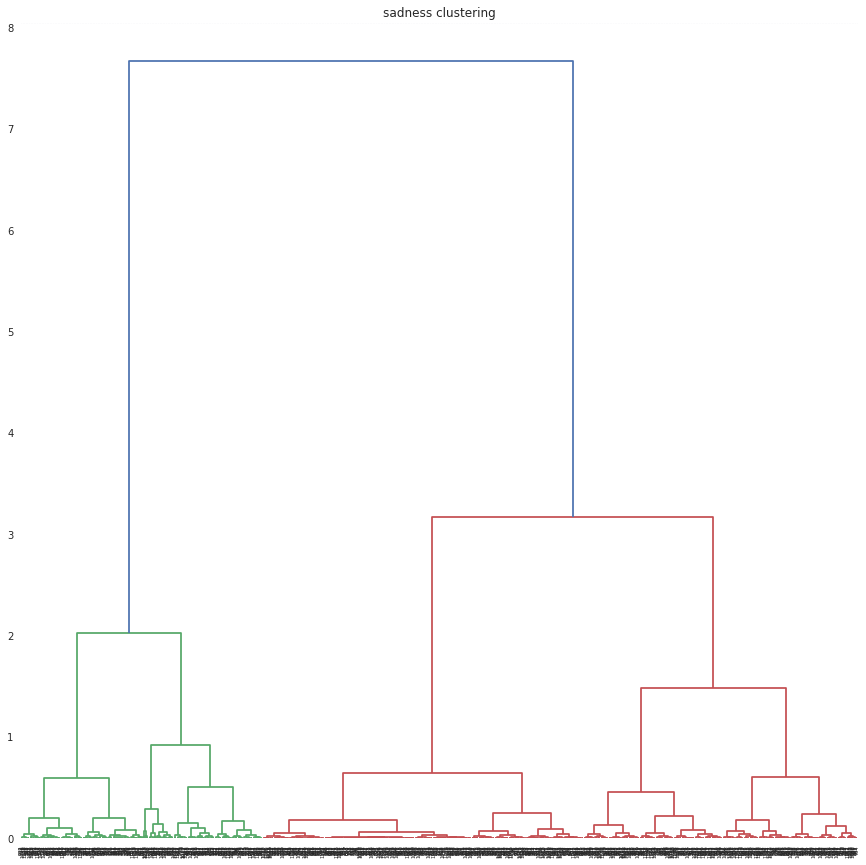

In [57]:
draw_dendrogram(arr[0], 'sadness clustering')

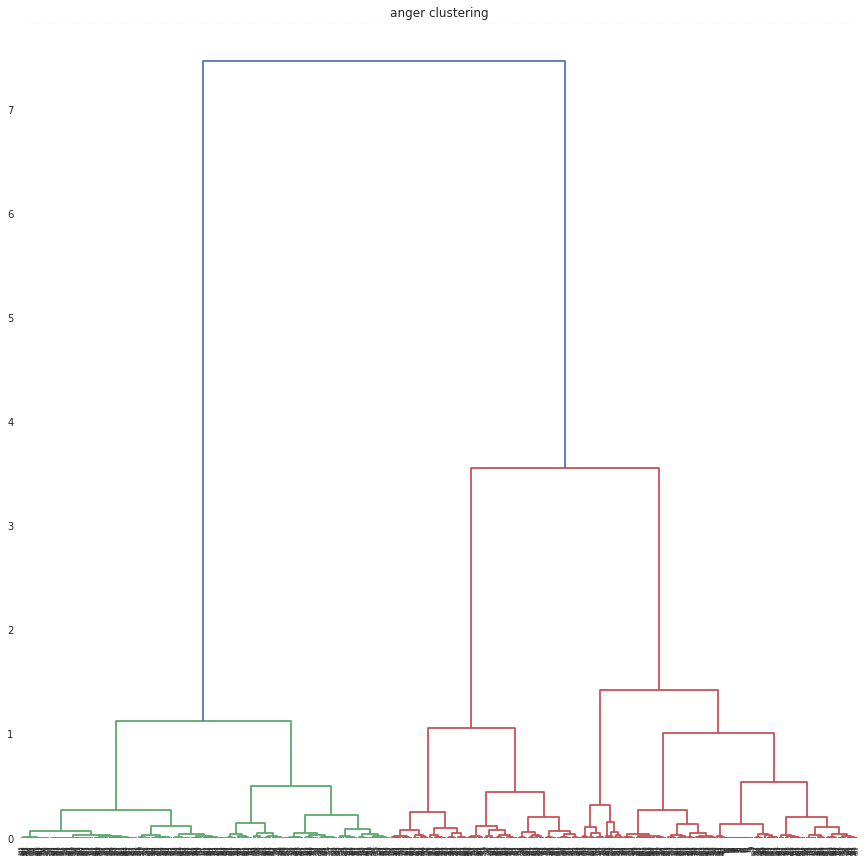

In [58]:
draw_dendrogram(arr[1], 'anger clustering')

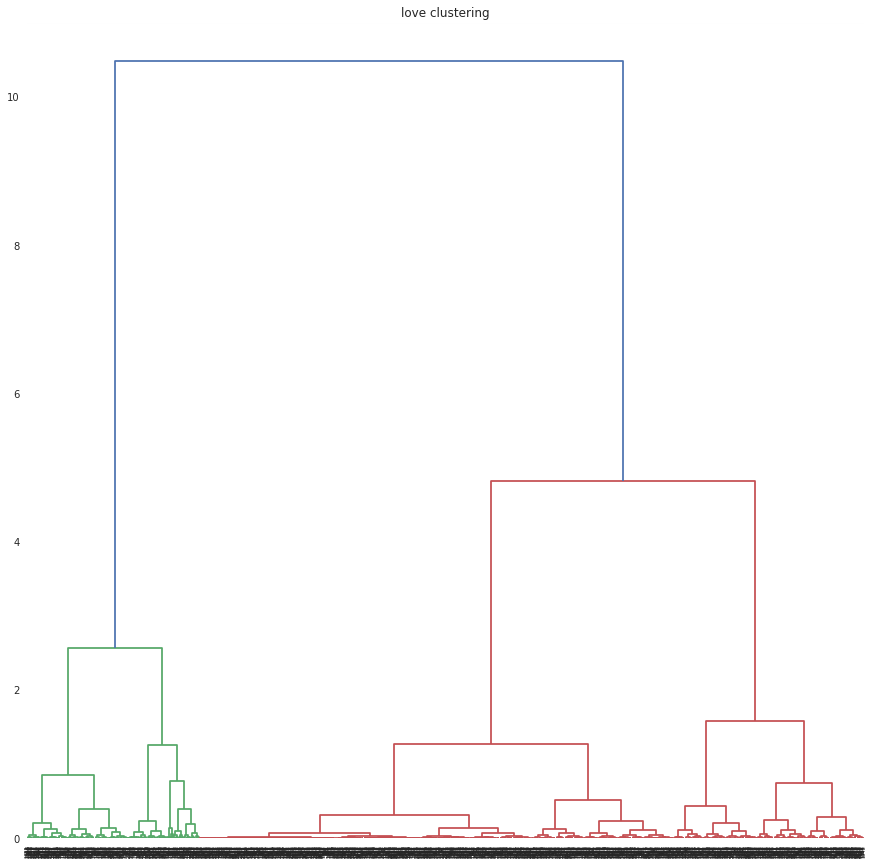

In [59]:
draw_dendrogram(arr[2], 'love clustering')

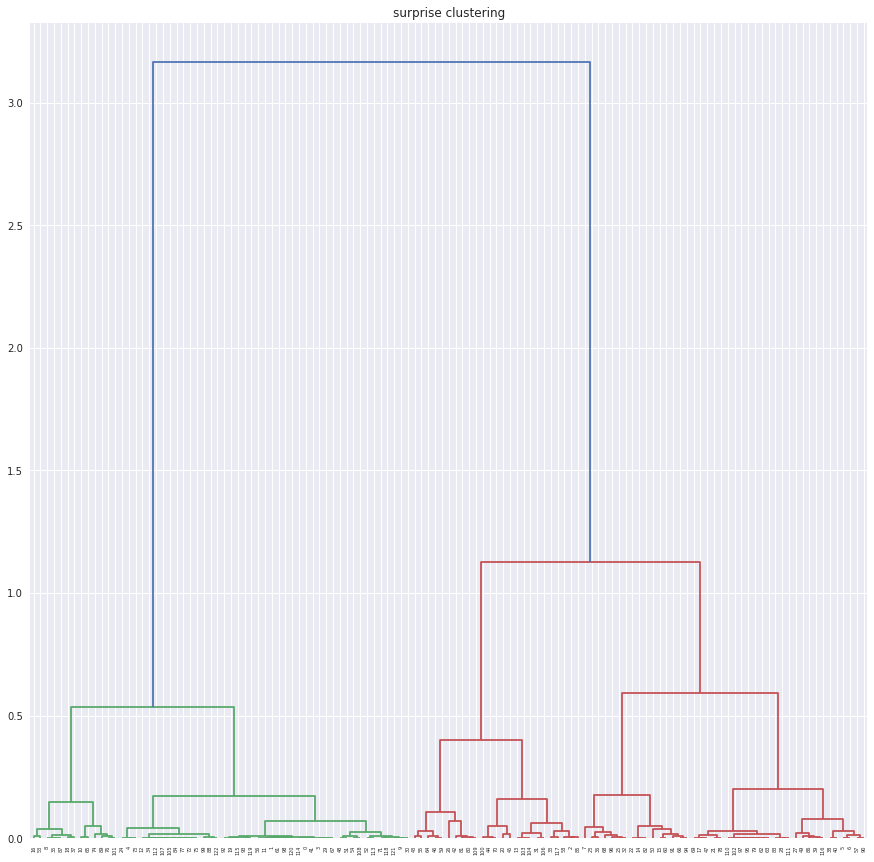

In [60]:
draw_dendrogram(arr[3], 'surprise clustering')

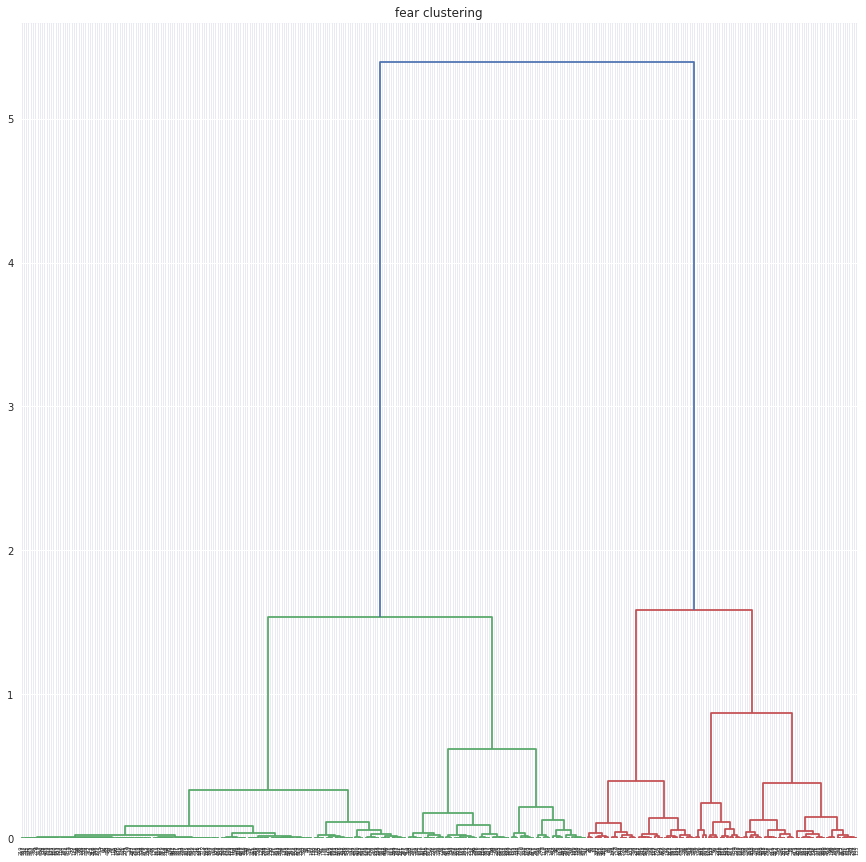

In [61]:
draw_dendrogram(arr[4], 'fear clustering')

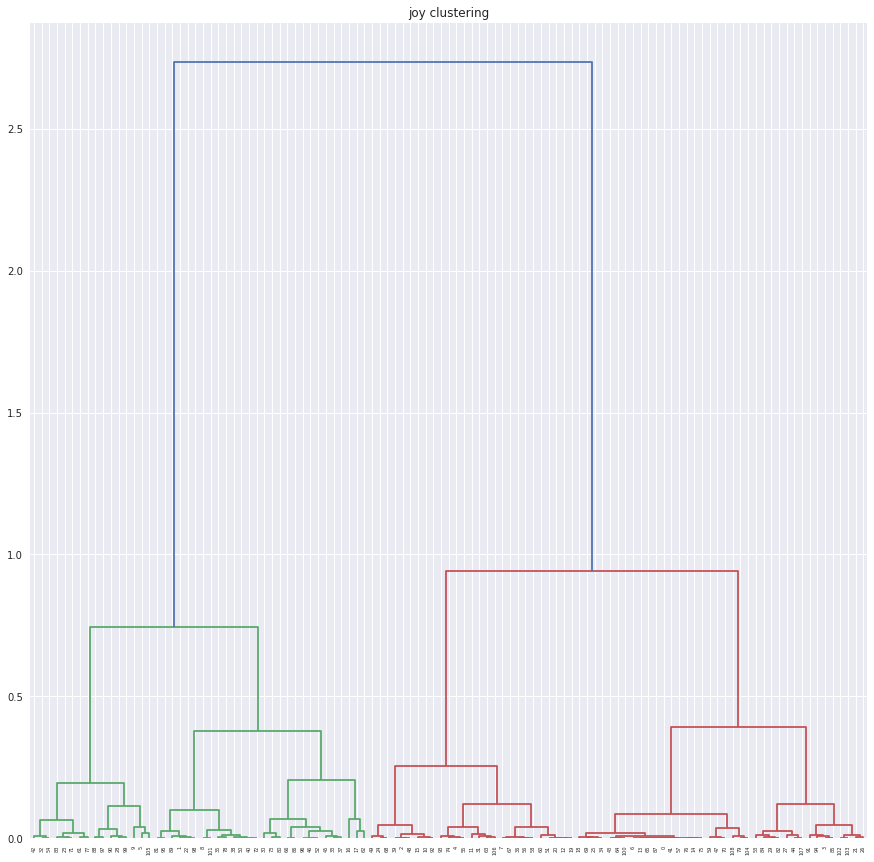

In [62]:
draw_dendrogram(arr[5], 'joy clustering')